## Imports


In [1]:
import os
import os.path as osp
import random
import sys

import cv2
# from tensorflow import keras
# from tensorflow.keras import layers, Dense, Input, InputLayer, Flatten
# from tensorflow.keras.models import Sequential, Model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torchvision.transforms as tt
from PIL import Image, ImageFile
from sklearn.model_selection import train_test_split

# from sklearn.datasets import load_files

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Data


## Load data


In [2]:
# set data paths
bins_path = r"..\data\bins"
nonbins_path = r"..\data\non-bins"


In [3]:
# convert all images to the same file format
def convert_img_type(to_type, dir, prefix):
    for i, filename in enumerate(os.listdir(dir)):
        name = f"{prefix}{'{:03}'.format(i)}.{to_type}"
        if not filename.endswith(f".{to_type}"):
            old_file_path = osp.join(dir, filename)
            img = Image.open(old_file_path)
            rgb_img = img.convert("RGB")
            img.close()
            rgb_img.save(osp.join(dir, name), quality=300)
            rgb_img.close()
            os.remove(old_file_path)
        else:
            os.rename(osp.join(dir, filename), osp.join(dir, name))


In [4]:
convert_img_type("png", bins_path, "bin_")


In [5]:
convert_img_type("png", nonbins_path, "nonbin_")


In [6]:
# preview data
def data_preview(dir):
    print(f"{osp.basename(dir)} data preview:")
    plt.figure(figsize=(20, 20))

    for i in range(5):
        file = random.choice(os.listdir(dir))
        image_path = os.path.join(dir, file)
        img = mpimg.imread(image_path)
        ax = plt.subplot(1, 5, i + 1)
        ax.title.set_text(file)
        plt.imshow(img)


bins data preview:


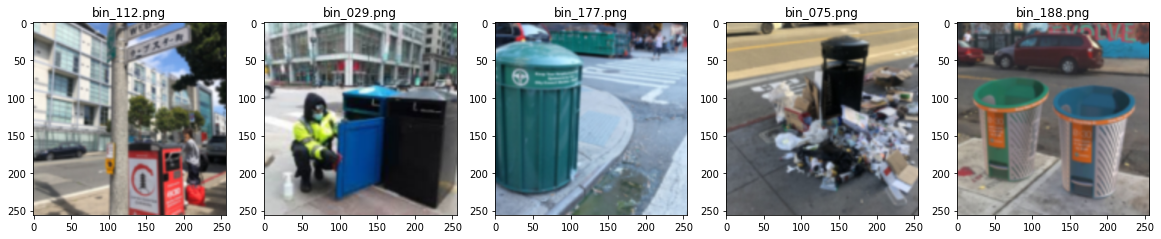

In [7]:
data_preview(bins_path)


non-bins data preview:


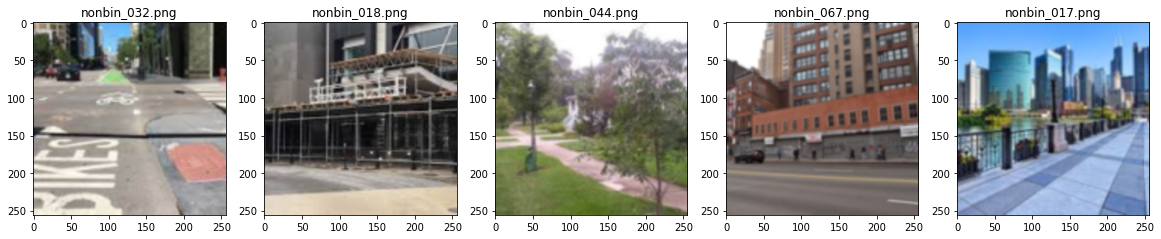

In [8]:
data_preview(nonbins_path)


## Preprocess data


In [9]:
# # compute min image dimensions
# def compute_dims(classes):
#     dim = sys.maxsize
#     for dir in classes:
#         for file in os.listdir(dir):
#             img = Image.open(osp.join(dir, file))
#             dim = min(dim, min(img.size))

#     return dim


# dim = compute_dims([bins_path, nonbins_path])
# print(f"Min image dimensionw: {dim}x{dim}")

dim = 256


### Crop and resize images


In [10]:
# resize images to min dimensions and center crop them
for dir in [bins_path, nonbins_path]:
    for file in os.listdir(dir):
        img = Image.open(osp.join(dir, file))
        resize = tt.functional.resize(img, dim)
        crop = tt.functional.center_crop(resize, dim)
        crop.save(osp.join(dir, file), quality=300)
        img.close()
        resize.close()
        crop.close()


In [11]:
bins = np.stack(
    [
        cv2.imread(osp.join(bins_path, x), cv2.IMREAD_GRAYSCALE)
        for x in os.listdir(bins_path)
    ]
)
nonbins = np.stack(
    [
        cv2.imread(osp.join(nonbins_path, x), cv2.IMREAD_GRAYSCALE)
        for x in os.listdir(nonbins_path)
    ]
)


In [12]:
images = np.concatenate([bins, nonbins])
y = np.asarray([1] * len(bins) + [0] * len(nonbins))
X = np.array(images, dtype=float)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=4
)
X_train = X_train.reshape(-1, dim, dim, 1)


# Model


In [14]:
# imports for the CNN
from __future__ import print_function
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from tensorflow.keras import Input, datasets, layers, models


## Build


In [15]:
# settings for CNN model
batch_size = 256
epochs = 30
save_dir = os.path.join("..", "models")
model_name = "bin-identifier.h5"


In [19]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5),
    ModelCheckpoint(
        filepath=osp.join(save_dir, "best_model.h5"),
        monitor="loss",
        save_best_only=True,
    ),
    TensorBoard(log_dir=osp.join("..", "logs")),
]


In [20]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            filters=16, kernel_size=(3, 3), activation="relu", input_shape=(256, 256, 3)
        ),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(axis=-1),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(axis=-1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(3, activation="softmax"),
    ]
)

learning_rate = 0.001
epochs = 100

opt = tf.keras.optimizers.Adam(
    learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5)
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy", "mse"]
)


aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest",
)


X_train = tf.random.normal((50, 256, 256, 3))
y_train = tf.random.uniform((50,), maxval=3, dtype=tf.int32)
history = model.fit(
    aug.flow(X_train, y_train, batch_size=2), epochs=epochs, callbacks=callbacks
)


Epoch 1/100
25/25 [==============================] - 28s 1s/step - loss: 4.3609 - accuracy: 0.2000 - mse: 1.2049
Epoch 2/100
25/25 [==============================] - 28s 1s/step - loss: 3.6333 - accuracy: 0.2800 - mse: 1.2053
Epoch 3/100
 9/25 [=========>....................] - ETA: 15s - loss: 2.9565 - accuracy: 0.2222 - mse: 1.0550

KeyboardInterrupt: 

## Train


In [ ]:
model.compile(
    loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy", "mse"]
)

# model.summary()

model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    verbose=1,
    shuffle=True,
    callbacks=callbacks,
)


## Evaluate Results
